In [15]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
from oiffile import imread
from PIL import Image
import random
import glob
import torch
import sys
import dognet
import functions
import skimage
from skimage.transform import resize
import tifffile as tiff
import torch
from tqdm import tnrange

In [16]:
# load network
netName = "notebooks/vermisA306060"
net = torch.load(netName)
# load and clip pre-computed medians of slices
medianTotal= np.double(np.load("datasets/vermisA/medianTotal.npy"))
medianclipped0 = np.maximum(medianTotal[0],np.max(medianTotal[0])/3)
medianclipped1 = np.maximum(medianTotal[1],np.max(medianTotal[1])/3)
medianclipped2 = np.maximum(medianTotal[2],np.max(medianTotal[2])/3)

In [75]:
# generate predicted synapse maps for all images
for i in tnrange(4,5):
    if i<10:
        n = '000%s' % (i)
    elif i <100:
        n = '00%s' % (i)
    else:
        n = '0%s' % (i)
    # load image
    fdir = r'E:\pcp2cre_syptom_568_mglur1_1to200_647_1to250_vgat_1to200_488_1to250\FV10__20190511_141336_vermisA/Track%s' % (n)
   
    im_name = 'Image%s_01.oib' % (n)
    image = imread(os.path.join(fdir,im_name))
    
    predictedZImages = []
    # evaluate each z-slice
    for z_slice in range(0,15):
        
        # normalize, shrink, and cut the image
        image_save = np.double(image[:,z_slice,:,:].transpose(2,1,0))  
        image_save[:,:,0] = image_save[:,:,0]/(medianclipped0[z_slice]*30)
        image_save[:,:,1] = image_save[:,:,1]/(medianclipped1[z_slice]*60)
        image_save[:,:,2] = image_save[:,:,2]/(medianclipped2[z_slice]*60)
        image_save = resize(image_save,(400,400), order=1, preserve_range=True)
        
        h=400
        w=400
        tol=30

        UL=(image_save[0:int(h/2+tol),0:int(w/2+tol),:]).transpose(2,1,0)       
        UR=(image_save[0:int(h/2+tol),int(w/2-tol):w,:]).transpose(2,1,0)
        LL=(image_save[int(h/2-tol):h,0:int(w/2+tol),:]).transpose(2,1,0)
        LR=(image_save[int(h/2-tol):h,int(w/2-tol):w,:]).transpose(2,1,0)
        
        smallPictures=[UL,UR,LL,LR]
        predictedImages=[]
        
        # generate prediction maps
        for j in range(0,4):
            inimg = np.transpose(resize(np.transpose(smallPictures[j],(2,1,0)),(230,230)),(2,0,1))
            outimg = functions.inference(net.to(torch.device("cuda")),inimg,get_inter=False,device=torch.device("cuda"))
 
            newImg = resize(outimg,(2,460,460), order=1, preserve_range=True)
            pMap = newImg[:1, :, :]
            predictedImages.append(pMap)
        
        #(x1,y1) as the top-left vertex and (x2,y2) as the bottom-right vertex, im[y1:y2, x1:x2] --delete
        Ntol=60
        
        # take mean image of the overlaps and remove edges of overlapping images
        top = (predictedImages[0][:, 0:h+Ntol, w-Ntol:w+Ntol] + predictedImages[1][:, 0:h+Ntol, 0:2*Ntol])/2
        left = (predictedImages[0][:, h-Ntol:h+Ntol, 0:w+Ntol] + predictedImages[2][:, 0:2*Ntol, 0:w+Ntol])/2
        bottom = (predictedImages[2][:, 0:h+Ntol, w-Ntol:w+Ntol] + predictedImages[3][:, 0:h+Ntol, 0:2*Ntol])/2
        right = (predictedImages[1][:, h-Ntol:h+Ntol, 0:w+Ntol] + predictedImages[3][:, 0:2*Ntol, 0:w+Ntol])/2
        middle = (top[:, h-Ntol:h+Ntol, 0:2*Ntol] + bottom[:, 0:2*Ntol, 0:2*Ntol] + right[:, 0:2*Ntol, 0:2*Ntol] + left[:, 0:2*Ntol, w-Ntol:w+Ntol])/4
        
        #taking min
        #top = np.minimum(predictedImages[0][:, 0:h+Ntol, w-Ntol:w+Ntol], predictedImages[1][:, 0:h+Ntol, 0:2*Ntol])
        #left = np.minimum(predictedImages[0][:, h-Ntol:h+Ntol, 0:w+Ntol], predictedImages[2][:, 0:2*Ntol, 0:w+Ntol])
        #bottom = np.minimum(predictedImages[2][:, 0:h+Ntol, w-Ntol:w+Ntol], predictedImages[3][:, 0:h+Ntol, 0:2*Ntol])
        #right = np.minimum(predictedImages[1][:, h-Ntol:h+Ntol, 0:w+Ntol], predictedImages[3][:, 0:2*Ntol, 0:w+Ntol])
        #middle1 = np.minimum(top[:, h-Ntol:h+Ntol, 0:2*Ntol], bottom[:, 0:2*Ntol, 0:2*Ntol])
        #middle2 = np.minimum(right[:, 0:2*Ntol, 0:2*Ntol], left[:, 0:2*Ntol, w-Ntol:w+Ntol])
        #middle = np.minimum(middle1, middle2)
              
        topLeft = predictedImages[0][:, 0:h-Ntol, 0:w-Ntol]
        topRight = predictedImages[1][:, 0:h-Ntol, 2*Ntol:]
        bottomLeft = predictedImages[2][:, 2*Ntol:, 0:w-Ntol]
        bottomRight = predictedImages[3][:, 2*Ntol:, 2*Ntol:]
        
        #stitch four prediction maps
        finalImage = np.zeros((1,800,800))
        finalImage[:, :h-Ntol, :w-Ntol] = topLeft
        finalImage[:, :h+Ntol, w-Ntol:w+Ntol] = top
        finalImage[:, :h-Ntol, w+Ntol:] = topRight
        finalImage[:, h-Ntol:h+Ntol, :w+Ntol] = left
        finalImage[:, h-Ntol:h+Ntol, w-Ntol:] = right
        finalImage[:, h+Ntol:, :w-Ntol] = bottomLeft
        finalImage[:, h-Ntol:, w-Ntol:w+Ntol] = bottom
        finalImage[:, h+Ntol:, w+Ntol:] = bottomRight
        finalImage[:, h-Ntol:h+Ntol, w-Ntol:w+Ntol] = middle 
        finalImage = finalImage/np.max(finalImage)
        finalImage = (80*finalImage).astype(np.uint16)        
        finalImage = np.flip(np.flip(finalImage.transpose(0,2,1)))
        
        # save all final prediction images in one z-stack
        predictedZImages.append(finalImage)
    
    stack = np.stack(predictedZImages, axis=1)
    # append prediction maps to image
    x = np.vstack((image, stack))
    x = x.astype(np.uint16)
        
    #fileName = r'C:\Users\CGuo\Desktop\vermisA/%s.tif' % (im_name[:12])
    fileName = r'C:\Users\CGuo\Desktop\img.tif'
    # save as a tiff file
    #tiff.imsave(fileName, x)

In [76]:
tiff.imsave(fileName, x)

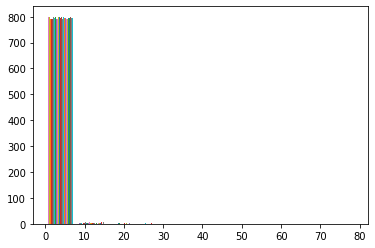

In [46]:
plt.hist(x[0][5])
plt.show()

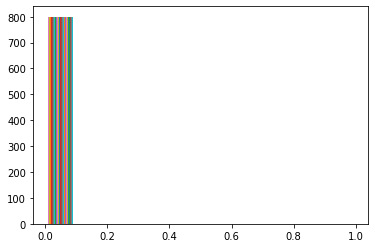

In [73]:
plt.hist(x[3][5])
plt.show()

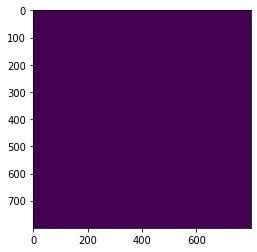

In [74]:
plt.imshow(x[3][5])

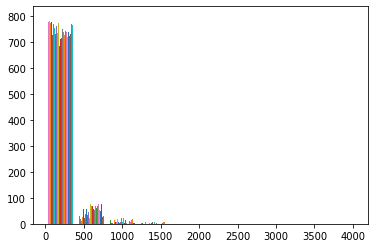

In [39]:
plt.hist(x[0][5])
plt.show()

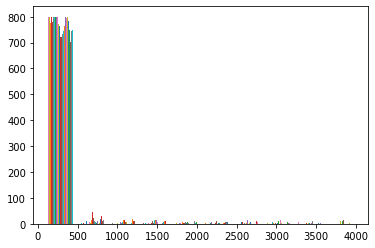

In [40]:
plt.hist(x[3][5])
plt.show()